# Training

Nick Sciarrilli <br>
Comp 4449 <br>
Midterm <br>
02.02.2022

In [1]:
import os
import json
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import pil_loader

In [2]:
torch.__version__

'1.10.2+cu102'

In [3]:
mapping = {
    'pedestrian': 0,
    'rider': 1,
    'car': 2,
    'truck': 3,
    'bus': 4,
    'train': 5,
    'motorcycle': 6,
    'bicycle': 7,
    'traffic light': 8,
    'traffic sign':9
}

In [4]:
# root = 'data/bdd100k'

# label_paths = glob.glob(
#     os.path.join(root, 'labels/train/*.json'))
# image_dir = os.path.join(root, 'images/100k/train')

# samples = []
# for label_path in label_paths:
#     image_path = os.path.join(
#         image_dir,
#         os.path.basename(label_path).replace('.json', '.jpg'))
#     if os.path.exists(image_path):
#         samples.append((image_path, label_path))

# index = 0
# image_path, label_path = samples[index]

# image = pil_loader(image_path)
# label = load_json(label_path)

In [5]:
# samples[0]

In [6]:
# label_path

In [7]:
# label['labels'][0]['category']

In [8]:
# labels = df.labels.iloc[0]

In [9]:
# target = {}
# target['boxes'] = []
# for label in labels:
#     if label['category'] in mapping:
#         print(label)
#         target['label'] = mapping[label['category']]
#         target['boxes'].append(label['box2d'])

# print()
# print(target)

In [10]:
# row = df.labels.iloc[0]

# labels = []
# boxes = []
# for label in row:
#     if label['category'] in mapping:
#         #print(label)
#         x1 = label['box2d']['x1']
#         x2 = label['box2d']['x2']
#         y1 = label['box2d']['y1']
#         y2 = label['box2d']['y2']
#         boxes.append(np.array([x1, y1, x2, y2]))
#         labels.append(mapping[label['category']])

# target = {}
# target['boxes'] = torch.tensor(boxes, dtype=torch.float)
# target['labels'] = torch.tensor(labels, dtype=torch.int64)
# #print()
# print(target)

In [11]:
def load_json(f):
    with open(f, 'r') as fp:
        return json.load(fp)


def save_json(obj, f, *args, **kwargs):
    with open(f, 'w') as fp:
        json.dump(obj, fp, *args, **kwargs)


class BDDDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.train = train
        self.transform = transform
        self.samples = None
        self.prepare()

    def prepare(self):
        self.samples = []
        if self.train:
            label_paths = glob.glob(
                os.path.join(self.root, 'labels/train/*.json'))[:10000]
            image_dir = os.path.join(self.root, 'images/100k/train')
        else:
            label_paths = glob.glob(
                os.path.join(self.root, 'labels/val/*.json'))
            image_dir = os.path.join(self.root, 'images/100k/val')

        for label_path in label_paths:
            image_path = os.path.join(
                image_dir,
                os.path.basename(label_path).replace('.json', '.jpg'))
            if os.path.exists(image_path):
                self.samples.append((image_path, label_path))

    def __getitem__(self, index):
        # TODO: handle label dict
        image_path, label_path = self.samples[index]
        #image = pil_loader(image_path)
        img = Image.open(image_path).convert("RGB")
        json_labels = load_json(label_path)

        mapping = {
            'pedestrian': 0,
            'rider': 1,
            'car': 2,
            'truck': 3,
            'bus': 4,
            'train': 5,
            'motorcycle': 6,
            'bicycle': 7,
            'traffic light': 8,
            'traffic sign':9
        }
        
        labels = []
        boxes = []
        for label in json_labels['labels']:
            if label['category'] in mapping:
                #print(label)
                x1 = label['box2d']['x1']
                #print(f'x1 {type(x1)}')
                x2 = label['box2d']['x2']
                y1 = label['box2d']['y1']
                y2 = label['box2d']['y2']
                boxes.append(np.array([x1, y1, x2, y2]))
                labels.append(mapping[label['category']])
                
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        image_id = torch.tensor([index])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        num_objs = len(boxes)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.LongTensor(labels)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transform is not None:
            img = self.transform(img)

        return img, target
    
    def __len__(self):
        return len(self.samples)

In [12]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

drive_dataset = BDDDataset('data/bdd100k', transform=transform)

In [13]:
len(drive_dataset)

10000

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
torch.manual_seed(0)

train_set, test_set = torch.utils.data.random_split(drive_dataset, [7000, 3000])

In [16]:
train_loader = DataLoader(train_set, batch_size=8, num_workers=4, collate_fn=collate_fn)
#val_loader = DataLoader(val_set, batch_size=8, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=8, num_workers=4, collate_fn=collate_fn)

In [17]:
#train_set.dataset.__getitem__(0)

In [18]:
it = iter(train_loader)

/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before conve

In [19]:
first = next(it)

In [20]:
#first

In [21]:
#first[0][0]

In [22]:
img = transforms.ToPILImage()(first[0][0].squeeze_(0))
img.size

(1280, 720)

In [23]:
boxes = first[1][0]['boxes']

In [24]:
#boxes

In [25]:
# for i in boxes:
#     print(i)

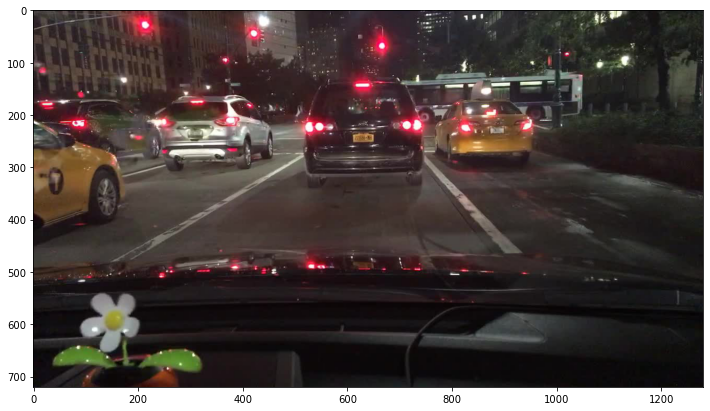

In [26]:
plt.figure(figsize=(12,7))
plt.imshow(img);
#plt.show()

In [27]:
colors = ['C'+str(i) for i in range(10)]

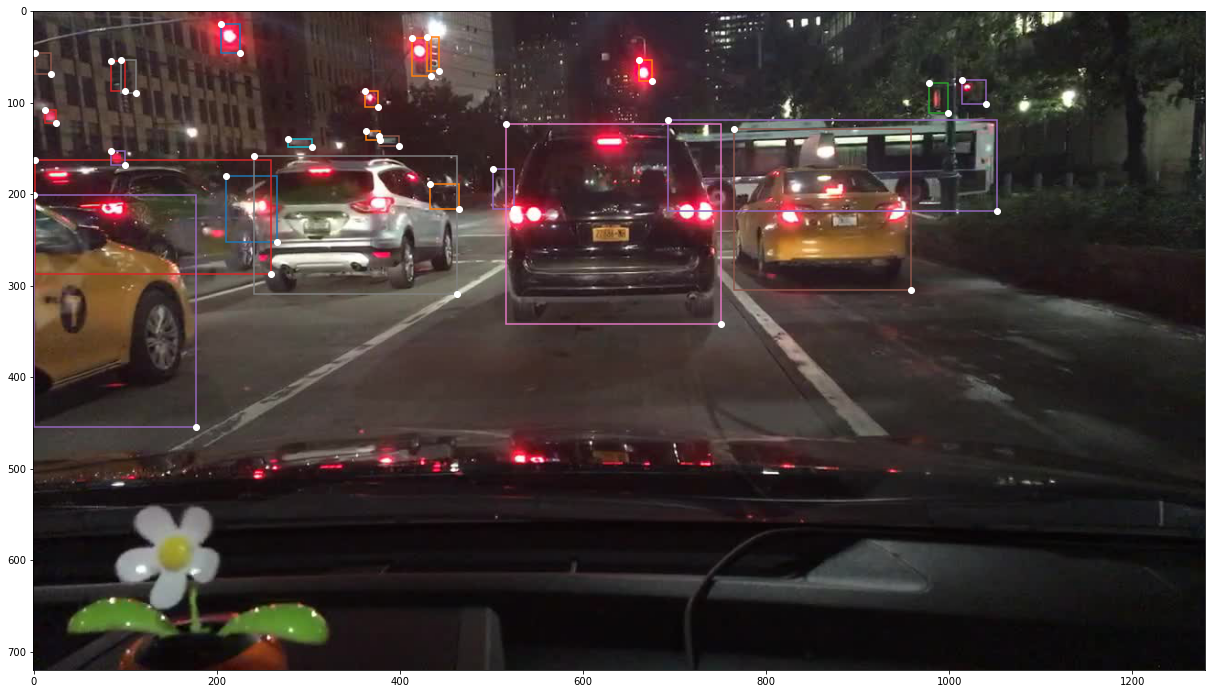

In [28]:
fig, ax = plt.subplots(figsize = (21,14))
ax.imshow(img)

idx = 0
for box in boxes:
    #print(box)
    idx += 1
    try:
        x1 = box[0]
        x2 = box[2]
        y1 = box[1]
        y2 = box[3]

        #print(x1, y1, x2, y2)

        x = x1
        y = y2
        w = x2 - x1
        h = y1 - y2

        plt.plot(x1, y1, marker='o', color="white")
        plt.plot(x2, y2, marker='o', color="white")
        color = np.random.choice(colors)
        ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

        cat = i['category']
        ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
    except:
        continue

In [33]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 10  # len(mapping)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 10

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [35]:
import utils
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.to(device)
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [36]:
#!pip3 install pycocotools

In [37]:
from engine import evaluate

from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)
    



/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before conve

Epoch: [0]  [  0/875]  eta: 0:19:58  lr: 0.000011  loss: 3.8332 (3.8332)  loss_classifier: 2.4501 (2.4501)  loss_box_reg: 0.9307 (0.9307)  loss_objectness: 0.3004 (0.3004)  loss_rpn_box_reg: 0.1519 (0.1519)  time: 1.3691  data: 0.5519  max mem: 9212
Epoch: [0]  [ 10/875]  eta: 0:12:17  lr: 0.000068  loss: 3.8332 (3.8282)  loss_classifier: 2.4194 (2.3709)  loss_box_reg: 0.8827 (0.8964)  loss_objectness: 0.3004 (0.3540)  loss_rpn_box_reg: 0.1987 (0.2069)  time: 0.8524  data: 0.0818  max mem: 9478
Epoch: [0]  [ 20/875]  eta: 0:11:44  lr: 0.000125  loss: 3.4056 (3.3847)  loss_classifier: 2.1141 (2.0546)  loss_box_reg: 0.8664 (0.8514)  loss_objectness: 0.2050 (0.2717)  loss_rpn_box_reg: 0.1978 (0.2070)  time: 0.7962  data: 0.0298  max mem: 9478
Epoch: [0]  [ 30/875]  eta: 0:11:27  lr: 0.000182  loss: 2.3394 (2.9532)  loss_classifier: 1.2456 (1.6992)  loss_box_reg: 0.7863 (0.8269)  loss_objectness: 0.1319 (0.2222)  loss_rpn_box_reg: 0.1968 (0.2049)  time: 0.7925  data: 0.0248  max mem: 9478


/home/ec2-user/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/ipykernel/__main__.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


creating index...
index created!
Test:  [  0/375]  eta: 0:07:46  model_time: 0.3794 (0.3794)  evaluator_time: 0.2141 (0.2141)  time: 1.2430  data: 0.6325  max mem: 9478
Test:  [100/375]  eta: 0:02:44  model_time: 0.3670 (0.3672)  evaluator_time: 0.1781 (0.1838)  time: 0.5983  data: 0.0251  max mem: 9478
Test:  [200/375]  eta: 0:01:44  model_time: 0.3673 (0.3677)  evaluator_time: 0.1801 (0.1844)  time: 0.5949  data: 0.0252  max mem: 9478
Test:  [300/375]  eta: 0:00:44  model_time: 0.3701 (0.3684)  evaluator_time: 0.1830 (0.1849)  time: 0.6227  data: 0.0257  max mem: 9478
Test:  [374/375]  eta: 0:00:00  model_time: 0.3689 (0.3686)  evaluator_time: 0.1754 (0.1855)  time: 0.5888  data: 0.0253  max mem: 9478
Test: Total time: 0:03:44 (0.5995 s / it)
Averaged stats: model_time: 0.3689 (0.3686)  evaluator_time: 0.1754 (0.1855)
Accumulating evaluation results...
DONE (t=3.87s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  

In [60]:
main()

NameError: name 'main' is not defined

In [38]:
# pick one image from the test set
img, _ = next(iter(test_loader))
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    preds = model([img[1].to(device)])


In [39]:
#preds

In [40]:
#img[1]

In [41]:
len(img)

8

In [42]:
len(preds)

1

In [43]:
#preds[0]

In [44]:
img[1].shape

torch.Size([3, 720, 1280])

In [45]:
img_sample = transforms.ToPILImage()(img[1].squeeze_(0))
img_sample.size

(1280, 720)

In [46]:
# preds[0]['boxes']

In [48]:
#boxes = prediction[0]['boxes']

In [49]:
float(boxes[0][0])

204.22174072265625

In [50]:
boxes[0]

tensor([204.2217,  13.9897, 224.8835,  45.4315])

In [51]:
#colors

In [52]:
mapping

{'pedestrian': 0,
 'rider': 1,
 'car': 2,
 'truck': 3,
 'bus': 4,
 'train': 5,
 'motorcycle': 6,
 'bicycle': 7,
 'traffic light': 8,
 'traffic sign': 9}

In [53]:
reverse_mapping = {v: k for k, v in mapping.items()}
reverse_mapping

{0: 'pedestrian',
 1: 'rider',
 2: 'car',
 3: 'truck',
 4: 'bus',
 5: 'train',
 6: 'motorcycle',
 7: 'bicycle',
 8: 'traffic light',
 9: 'traffic sign'}

In [54]:
# for i in prediction[0]['labels']:
#     print(reverse_mapping[int(i)])

In [55]:
#reverse_mapping[2]

In [56]:
#preds[0]

In [57]:
def show_img_from_pred(loader):
    images, _ = next(iter(loader))
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        preds = model([images[0].to(device)])

    image = transforms.ToPILImage()(images[0].squeeze_(0))
    fig, ax = plt.subplots(figsize = (21,14))
    ax.imshow(image)
    idx = 0
    
    boxes = preds[0]['boxes']
    labels = preds[0]['labels']
    
    for box, lab in zip(boxes, labels):
        #print(lab)
        cat = reverse_mapping[int(lab)]
        #print(box, cat)
        idx += 1
        try:
            x1 = float(box[0])
            x2 = float(box[2])
            y1 = float(box[1])
            y2 = float(box[3])

            #print(x1, y1, x2, y2)
            x = x1
            y = y2
            w = x2 - x1
            h = y1 - y2
            
            #plt.plot(x1, y1, marker='o', color="white")
            #plt.plot(x2, y2, marker='o', color="white")
            color = np.random.choice(colors)
            #print(color)
            ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

            #print(int(lab))
            cat = reverse_mapping[int(lab)]
            #print(cat)
            ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)

        except:
            continue
        
    #plt.show()

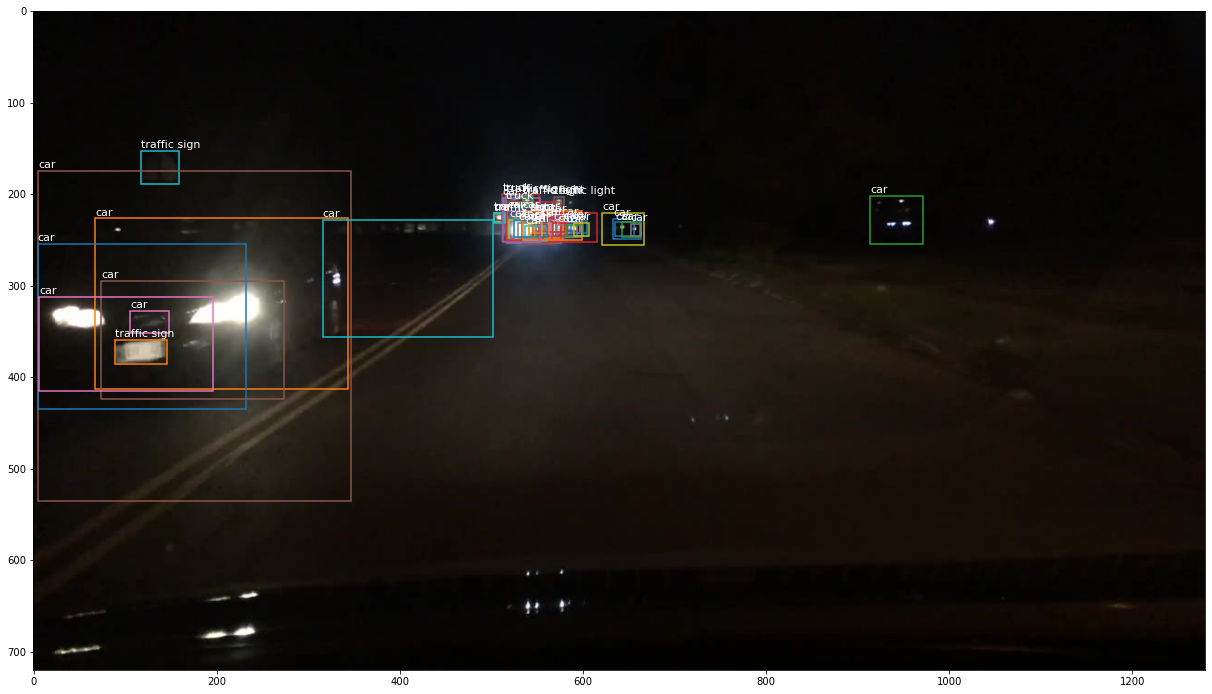

In [58]:
show_img_from_pred(test_loader)
#show_img_from_pred(val_loader)

# Appendix

In [ ]:
#
# searching for labels without bounding boxes which is throwing an error
#

# no_boxes = []

# for image, labels, fname in train_loader:
#     if not len(labels[0]['boxes']):
#         no_boxes.append(fname)
#         print(fname)
    

In [ ]:

'''

no_boxes


[('data/bdd100k/images/100k/train/afe9a05d-c03c340e.jpg',),
 ('data/bdd100k/images/100k/train/16c5943e-b79c87c3.jpg',),
 ('data/bdd100k/images/100k/train/99b37fef-a772473c.jpg',),
 ('data/bdd100k/images/100k/train/3cfdf1e3-f9e91931.jpg',)]

'''

In [ ]:
# count = 0
# for images, targets in train_loader:
#     print(images, targets)
#     if count > 2:
#         break
#     optimizer.zero_grad()
#     images = list(image for image in images)
#     targets = [{k: v for k, v in t.items()} for t in targets]
#     count += 1

In [ ]:
# %%time
# model.to(device)
# for epoch in range(num_epochs):
#     epoch_loss = 0
#     for images, targets in train_loader:
#         #print(f'images {images}, targets {targets}')
#         optimizer.zero_grad()
#         images = list(image for image in images)
#         targets = [{k: v for k, v in t.items()} for t in targets]

#         output = model(images, targets)
#         # print(loss_dict)
#         losses = sum(loss for loss in output.values())
#         epoch_loss += losses.item()

#         losses.backward()
#         optimizer.step()
#     print(f"loss for epoch {epoch}: {epoch_loss / len(train_loader)}")

In [ ]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model.to(device)
# dataset = BDDDataset('data/bdd100k', transform=transform)
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn=collate_fn)
# # For Training
# images,targets = next(iter(data_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x) 

In [ ]:
#features, labels = next(iter(val_loader))

In [ ]:
#preds = model(features)

In [ ]:
#preds[1]

In [ ]:
#features[1]

In [ ]:
# img = transforms.ToPILImage()(features[1][0].squeeze_(0))
# img.size

In [ ]:
# boxes = preds[1]['boxes']

In [ ]:
#boxes

In [ ]:
# for i in boxes:
#     print(i)

In [ ]:
# plt.figure(figsize=(12,7))
# plt.imshow(img);
# #plt.show()

In [ ]:
colors

In [ ]:
# fig, ax = plt.subplots(figsize = (21,14))
# ax.imshow(img)

# idx = 0
# for box in boxes:
#     #print(box)
#     idx += 1
#     try:
#         x1 = box[0]
#         x2 = box[2]
#         y1 = box[1]
#         y2 = box[3]

#         #print(x1, y1, x2, y2)

#         x = x1
#         y = y2
#         w = x2 - x1
#         h = y1 - y2

#         #plt.plot(x1, y1, marker='o', color="white")
#         #plt.plot(x2, y2, marker='o', color="white")
#         color = np.random.choice(colors)
#         ax.add_patch(Rectangle((x,y), w, h, linewidth=1.5, edgecolor=color, facecolor='none'))

#         cat = i['category']
#         ax.text(x, y1-12, cat, verticalalignment='top', color='white', fontsize=11)
#     except:
#         continue